In [2]:
import numpy as np
import pandas as pd
import scipy as sc

from importlib import reload
from time import time
import matplotlib

import utils

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [3]:
# load data with PTM labels and ground-truth and predicted disorder labels
# processed in process-data-and-train-model.ipynb
ptm_idr_df = pd.read_csv('ptm_idr.csv')
ptm_idr_df

,protein_id,AA,position,ac,ac_reg,ga,gl,gl_reg,m,m_reg,...,nAA_28_180_pae_smooth5,nAA_28_180_pae_smooth10,nAA_28_180_pae_smooth15,nAA_28_180_pae_smooth20,nAA_28_180_pae_smooth25,nAA_28_180_pae_smooth30,nAA_28_180_pae_smooth35,disordered,ordered,pred_disordered
0,O00151,K,22,1,0,0,0,0,0,0,...,72.818182,77.428571,74.774194,74.951220,75.319149,76.500000,76.877193,0.0,1.0,0.022424
1,O00151,K,71,0,0,0,0,0,0,0,...,75.000000,77.809524,72.483871,67.268293,64.294118,61.786885,59.450704,0.0,1.0,0.057403
2,O00151,K,87,0,0,0,0,0,1,0,...,33.000000,41.095238,41.419355,43.170732,43.764706,43.491803,44.070423,0.0,1.0,0.245860
3,O00151,T,34,0,0,0,0,0,0,0,...,80.727273,78.380952,79.193548,80.560976,77.980392,77.754098,76.695652,0.0,1.0,0.017603
4,O00168,S,82,0,0,0,0,0,0,0,...,18.454545,16.761905,16.384615,16.806452,17.638889,19.756098,22.000000,0.0,1.0,0.433978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10797,Q9Y6W3,S,697,0,0,0,0,0,0,0,...,101.818182,105.047619,103.870968,113.097561,115.352941,124.655738,129.366197,0.0,1.0,0.006763
10798,Q9Y6W3,S,700,0,0,0,0,0,0,0,...,93.454545,98.857143,102.258065,110.756098,110.725490,121.901639,129.845070,0.0,1.0,0.006944
10799,Q9Y6W6,K,380,0,0,0,0,0,0,0,...,114.909091,129.333333,127.290323,123.536585,124.137255,128.213115,129.056338,0.0,1.0,0.004483
10800,Q9Y6Y9,Y,131,0,0,0,0,0,0,0,...,97.272727,85.666667,88.677419,94.707317,92.862745,87.200000,84.169231,0.0,1.0,0.016282


In [172]:
# main experiment: computing model-assisted and classical confidence intervals
# on the odds ratio
reload(utils)
N = len(ptm_idr_df)
ns = np.logspace(np.log10(200), np.log10(N - 100), num=20, base=10).astype(int)
n_trial = 1000ccc
ptm_names = ['p', 'ub', 'ac']
alpha = 0.1
grid_spacing = 1e-3
print_every = 200
save = True
save_fname = 'sampling-sites-wor-cis-logistic-111022.npz'

mu1maici_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu1claci_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu1cov_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu0maici_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu0claci_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu0cov_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
omaici_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
oclaci_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
ocov_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])

for p_idx, ptm_name in enumerate(ptm_names):
    for n_idx, n in enumerate(ns):
        
        t0 = time()
        print('PTM = {}, n = {}'.format(ptm_name, n))
        
        for t in range(n_trial):

            lab_idx = np.random.choice(N, n, replace=False)
            result = utils.get_odds_ratio_betting_ci(
                ptm_idr_df, ptm_name, lab_idx, alpha, grid_spacing=grid_spacing, verbose=False
            )
            o, o_mai_ci, o_cla_ci, mu1, mu1_mai_ci, mu1_cla_ci, mu0, mu0_mai_ci, mu0_cla_ci = result

            # record results
            mu1maici_pxnxtx2[p_idx, n_idx, t] = mu1_mai_ci
            mu1claci_pxnxtx2[p_idx, n_idx, t] = mu1_cla_ci
            mu1cov_pxnxtx2[p_idx, n_idx, t, 0] = (mu1 >= mu1_mai_ci[0]) & (mu1 <= mu1_mai_ci[1])
            mu1cov_pxnxtx2[p_idx, n_idx, t, 1] = (mu1 >= mu1_cla_ci[0]) & (mu1 <= mu1_cla_ci[1])
            mu0maici_pxnxtx2[p_idx, n_idx, t] = mu0_mai_ci
            mu0claci_pxnxtx2[p_idx, n_idx, t] = mu0_cla_ci
            mu0cov_pxnxtx2[p_idx, n_idx, t, 0] = (mu0 >= mu0_mai_ci[0]) & (mu0 <= mu0_mai_ci[1])
            mu0cov_pxnxtx2[p_idx, n_idx, t, 1] = (mu0 >= mu0_cla_ci[0]) & (mu0 <= mu0_cla_ci[1])
            omaici_pxnxtx2[p_idx, n_idx, t] = o_mai_ci
            oclaci_pxnxtx2[p_idx, n_idx, t] = o_cla_ci
            ocov_pxnxtx2[p_idx, n_idx, t, 0] = (o >= o_mai_ci[0]) & (o <= o_mai_ci[1])
            ocov_pxnxtx2[p_idx, n_idx, t, 1] = (o >= o_cla_ci[0]) & (o <= o_cla_ci[1])
            
            if (t + 1) % print_every == 0:
                print('  Done with {} trials. {:d} s'.format(t + 1, int(time() - t0)))
            
        print('  Average model-assisted CI length: {:.2f}'.format(
            np.mean(omaici_pxnxtx2[p_idx, n_idx, :, 1] - omaici_pxnxtx2[p_idx, n_idx, :, 0])))
        print('  Average classical CI length: {:.2f}'.format(
            np.mean(oclaci_pxnxtx2[p_idx, n_idx, :, 1] - oclaci_pxnxtx2[p_idx, n_idx, :, 0])))
        print('  Model-assisted CI coverage: {:.2f}'.format(np.mean(ocov_pxnxtx2[p_idx, n_idx, :, 0])))
        print('  Classical CI coverage: {:.2f}'.format(np.mean(ocov_pxnxtx2[p_idx, n_idx, :, 1])))
        print('{:d} s'.format(int(time() - t0)))
        if save:
            np.savez(
                save_fname,
                mu1maici_pxnxtx2=mu1maici_pxnxtx2,
                mu1claci_pxnxtx2=mu1claci_pxnxtx2,
                mu1cov_pxnxtx2=mu1cov_pxnxtx2,
                mu0maici_pxnxtx2=mu0maici_pxnxtx2,
                mu0claci_pxnxtx2=mu0claci_pxnxtx2,
                mu0cov_pxnxtx2=mu0cov_pxnxtx2,
                omaici_pxnxtx2=omaici_pxnxtx2,
                oclaci_pxnxtx2=oclaci_pxnxtx2,
                ocov_pxnxtx2=ocov_pxnxtx2
            )

PTM = p, n = 200
  Done with 200 trials. 61 s
  Done with 400 trials. 123 s
  Done with 600 trials. 184 s
  Done with 800 trials. 246 s
  Done with 1000 trials. 307 s
  Average model-assisted CI length: inf
  Average classical CI length: 16.55
  Model-assisted CI coverage: 1.00
  Classical CI coverage: 0.99
307 s
PTM = p, n = 246
  Done with 200 trials. 63 s
  Done with 400 trials. 126 s
  Done with 600 trials. 189 s
  Done with 800 trials. 252 s
  Done with 1000 trials. 315 s
  Average model-assisted CI length: 4.27
  Average classical CI length: 9.52
  Model-assisted CI coverage: 1.00
  Classical CI coverage: 0.98
315 s
PTM = p, n = 304
  Done with 200 trials. 64 s
  Done with 400 trials. 129 s
  Done with 600 trials. 194 s
  Done with 800 trials. 258 s
  Done with 1000 trials. 322 s
  Average model-assisted CI length: 3.39
  Average classical CI length: 6.99
  Model-assisted CI coverage: 1.00
  Classical CI coverage: 0.99
322 s
PTM = p, n = 374
  Done with 200 trials. 66 s
  Done wi

  Done with 200 trials. 71 s
  Done with 400 trials. 142 s
  Done with 600 trials. 213 s
  Done with 800 trials. 285 s
  Done with 1000 trials. 356 s
  Average model-assisted CI length: 0.37
  Average classical CI length: 0.63
  Model-assisted CI coverage: 1.00
  Classical CI coverage: 0.99
356 s
PTM = ub, n = 866
  Done with 200 trials. 74 s
  Done with 400 trials. 150 s
  Done with 600 trials. 225 s
  Done with 800 trials. 300 s
  Done with 1000 trials. 375 s
  Average model-assisted CI length: 0.32
  Average classical CI length: 0.52
  Model-assisted CI coverage: 0.99
  Classical CI coverage: 0.98
375 s
PTM = ub, n = 1068
  Done with 200 trials. 79 s
  Done with 400 trials. 158 s
  Done with 600 trials. 237 s
  Done with 800 trials. 316 s
  Done with 1000 trials. 396 s
  Average model-assisted CI length: 0.29
  Average classical CI length: 0.46
  Model-assisted CI coverage: 0.99
  Classical CI coverage: 0.98
396 s
PTM = ub, n = 1317
  Done with 200 trials. 84 s
  Done with 400 trial

  Done with 200 trials. 110 s
  Done with 400 trials. 220 s
  Done with 600 trials. 331 s
  Done with 800 trials. 441 s
  Done with 1000 trials. 552 s
  Average model-assisted CI length: 0.54
  Average classical CI length: 0.83
  Model-assisted CI coverage: 0.98
  Classical CI coverage: 0.98
552 s
PTM = ac, n = 3045
  Done with 200 trials. 121 s
  Done with 400 trials. 242 s
  Done with 600 trials. 363 s
  Done with 800 trials. 489 s
  Done with 1000 trials. 613 s
  Average model-assisted CI length: 0.48
  Average classical CI length: 0.74
  Model-assisted CI coverage: 0.99
  Classical CI coverage: 0.98
613 s
PTM = ac, n = 3755
  Done with 200 trials. 135 s
  Done with 400 trials. 271 s
  Done with 600 trials. 407 s
  Done with 800 trials. 542 s
  Done with 1000 trials. 677 s
  Average model-assisted CI length: 0.42
  Average classical CI length: 0.80
  Model-assisted CI coverage: 0.99
  Classical CI coverage: 0.99
677 s
PTM = ac, n = 4630
  Done with 200 trials. 153 s
  Done with 400 

In [ ]:
reload(utils)
N = len(ptm_idr_df)
ns = np.logspace(np.log10(200), np.log10(N - 100), num=20, base=10).astype(int)
ns = ns[np.where(ns >= 1068)[0][0] :]
n_trial = 1000
ptm_names = ['ac']
alpha = 0.1
grid_spacing = 1e-3
print_every = 200
save = True
save_fname = 'sampling-sites-wor-cis-logistic-111022_3.npz'

mu1maici_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu1claci_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu1cov_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu0maici_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu0claci_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
mu0cov_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
omaici_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
oclaci_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])
ocov_pxnxtx2 = np.zeros([len(ptm_names), ns.size, n_trial, 2])

for p_idx, ptm_name in enumerate(ptm_names):
    for n_idx, n in enumerate(ns):
        
        t0 = time()
        print('PTM = {}, n = {}'.format(ptm_name, n))
        
        for t in range(n_trial):

            lab_idx = np.random.choice(N, n, replace=False)
            result = utils.get_odds_ratio_betting_ci(
                ptm_idr_df, ptm_name, lab_idx, alpha, grid_spacing=grid_spacing, verbose=False
            )
            o, o_mai_ci, o_cla_ci, mu1, mu1_mai_ci, mu1_cla_ci, mu0, mu0_mai_ci, mu0_cla_ci = result

            # record results
            mu1maici_pxnxtx2[p_idx, n_idx, t] = mu1_mai_ci
            mu1claci_pxnxtx2[p_idx, n_idx, t] = mu1_cla_ci
            mu1cov_pxnxtx2[p_idx, n_idx, t, 0] = (mu1 >= mu1_mai_ci[0]) & (mu1 <= mu1_mai_ci[1])
            mu1cov_pxnxtx2[p_idx, n_idx, t, 1] = (mu1 >= mu1_cla_ci[0]) & (mu1 <= mu1_cla_ci[1])
            mu0maici_pxnxtx2[p_idx, n_idx, t] = mu0_mai_ci
            mu0claci_pxnxtx2[p_idx, n_idx, t] = mu0_cla_ci
            mu0cov_pxnxtx2[p_idx, n_idx, t, 0] = (mu0 >= mu0_mai_ci[0]) & (mu0 <= mu0_mai_ci[1])
            mu0cov_pxnxtx2[p_idx, n_idx, t, 1] = (mu0 >= mu0_cla_ci[0]) & (mu0 <= mu0_cla_ci[1])
            omaici_pxnxtx2[p_idx, n_idx, t] = o_mai_ci
            oclaci_pxnxtx2[p_idx, n_idx, t] = o_cla_ci
            ocov_pxnxtx2[p_idx, n_idx, t, 0] = (o >= o_mai_ci[0]) & (o <= o_mai_ci[1])
            ocov_pxnxtx2[p_idx, n_idx, t, 1] = (o >= o_cla_ci[0]) & (o <= o_cla_ci[1])
            
            if (t + 1) % print_every == 0:
                print('  Done with {} trials. {:d} s'.format(t + 1, int(time() - t0)))
            
        print('  Average model-assisted CI length: {:.2f}'.format(
            np.mean(omaici_pxnxtx2[p_idx, n_idx, :, 1] - omaici_pxnxtx2[p_idx, n_idx, :, 0])))
        print('  Average classical CI length: {:.2f}'.format(
            np.mean(oclaci_pxnxtx2[p_idx, n_idx, :, 1] - oclaci_pxnxtx2[p_idx, n_idx, :, 0])))
        print('  Model-assisted CI coverage: {:.2f}'.format(np.mean(ocov_pxnxtx2[p_idx, n_idx, :, 0])))
        print('  Classical CI coverage: {:.2f}'.format(np.mean(ocov_pxnxtx2[p_idx, n_idx, :, 1])))
        print('{:d} s'.format(int(time() - t0)))
        if save:
            np.savez(
                save_fname,
                mu1maici_pxnxtx2=mu1maici_pxnxtx2,
                mu1claci_pxnxtx2=mu1claci_pxnxtx2,
                mu1cov_pxnxtx2=mu1cov_pxnxtx2,
                mu0maici_pxnxtx2=mu0maici_pxnxtx2,
                mu0claci_pxnxtx2=mu0claci_pxnxtx2,
                mu0cov_pxnxtx2=mu0cov_pxnxtx2,
                omaici_pxnxtx2=omaici_pxnxtx2,
                oclaci_pxnxtx2=oclaci_pxnxtx2,
                ocov_pxnxtx2=ocov_pxnxtx2
            )

PTM = ac, n = 1068
  Done with 200 trials. 80 s
  Done with 400 trials. 157 s
  Done with 600 trials. 237 s
  Done with 800 trials. 316 s


## Plot results

In [7]:
d = np.load('sampling-sites-wor-cis-logistic-111022.npz')
mu1maici_pxnxtx2 = d['mu1maici_pxnxtx2']
mu1claci_pxnxtx2 = d['mu1claci_pxnxtx2']
mu0maici_pxnxtx2 = d['mu0maici_pxnxtx2']
mu0claci_pxnxtx2 = d['mu0claci_pxnxtx2']
omaici_pxnxtx2 = d['omaici_pxnxtx2']
oclaci_pxnxtx2 = d['oclaci_pxnxtx2']

d2 = np.load('sampling-sites-wor-cis-logistic-111022_2.npz')
mu1maici_pxnxtx2_2 = d2['mu1maici_pxnxtx2']
mu1claci_pxnxtx2_2 = d2['mu1claci_pxnxtx2']
mu0maici_pxnxtx2_2 = d2['mu0maici_pxnxtx2']
mu0claci_pxnxtx2_2 = d2['mu0claci_pxnxtx2']
omaici_pxnxtx2_2 = d2['omaici_pxnxtx2']
oclaci_pxnxtx2_2 = d2['oclaci_pxnxtx2']

mu1maici_pxnxtx2 = np.concatenate([mu1maici_pxnxtx2[: 2], mu1maici_pxnxtx2_2[: 2]], axis=2)
print(mu1maici_pxnxtx2.shape)
mu1claci_pxnxtx2 = np.concatenate([mu1claci_pxnxtx2[: 2], mu1claci_pxnxtx2_2[: 2]], axis=2)
print(mu1claci_pxnxtx2.shape)
mu0maici_pxnxtx2 = np.concatenate([mu0maici_pxnxtx2[: 2], mu0maici_pxnxtx2_2[: 2]], axis=2)
print(mu0maici_pxnxtx2.shape)
mu0claci_pxnxtx2 = np.concatenate([mu0claci_pxnxtx2[: 2], mu0claci_pxnxtx2_2[: 2]], axis=2)
print(mu0claci_pxnxtx2.shape)
omaici_pxnxtx2 = np.concatenate([omaici_pxnxtx2[: 2], omaici_pxnxtx2_2[: 2]], axis=2)
print(omaici_pxnxtx2.shape)
oclaci_pxnxtx2 = np.concatenate([oclaci_pxnxtx2[: 2], oclaci_pxnxtx2_2[: 2]], axis=2)
print(oclaci_pxnxtx2.shape)

(2, 20, 2000, 2)
(2, 20, 2000, 2)
(2, 20, 2000, 2)
(2, 20, 2000, 2)
(2, 20, 2000, 2)
(2, 20, 2000, 2)


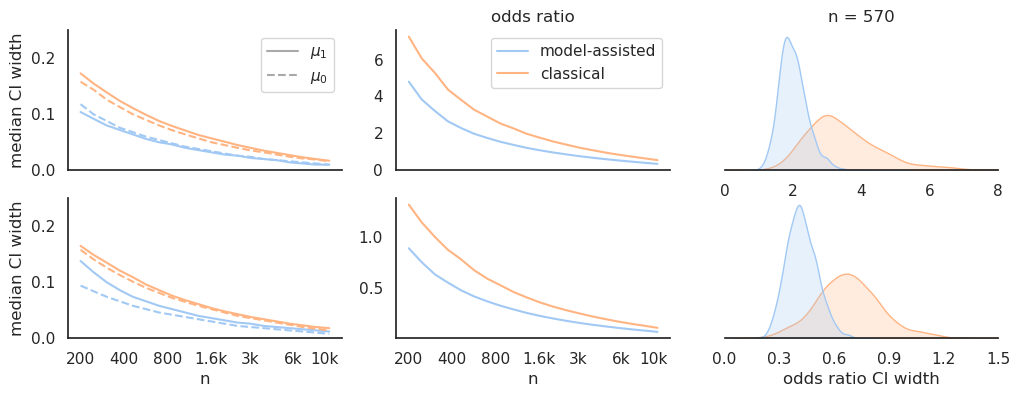

In [193]:
sns.set_theme(style='white', palette="pastel")
n_idx = np.where(ns >= 500)[0][0]
ptm_names = ['p', 'ub']
fig, axs = plt.subplots(len(ptm_names), 3, figsize=(12, len(ptm_names) * 2))

t = mu1maici_pxnxtx2.shape[2]
inference_2t = t * ['model-assisted'] + t * ['classical']
ns_xticks = [200, 400, 800, 1600, 3000, 6000, 10000]
ns_xticklabels = [200, 400, 800, '1.6k', '3k', '6k', '10k']

hist_xlims = [[0, 8], [0, 1.5]]
hist_xticks = [np.arange(0, 9, 2), np.arange(0, 1.6, 0.3)]
for p_idx, ptm_name in enumerate(ptm_names):
    
    # ===== left subplots =====
    
    # mu1
    mu1maicilen_n = np.median(mu1maici_pxnxtx2[p_idx, :, :, 1] - mu1maici_pxnxtx2[p_idx, :, :, 0], axis=1)
    mu1clacilen_n = np.median(mu1claci_pxnxtx2[p_idx, :, :, 1] - mu1claci_pxnxtx2[p_idx, :, :, 0], axis=1)
    axs[p_idx, 0].plot(ns, mu1maicilen_n)
    axs[p_idx, 0].plot(ns, mu1clacilen_n)
    
    # mu0
    mu0maicilen_n = np.median(mu0maici_pxnxtx2[p_idx, :, :, 1] - mu0maici_pxnxtx2[p_idx, :, :, 0], axis=1)
    mu0clacilen_n = np.median(mu0claci_pxnxtx2[p_idx, :, :, 1] - mu0claci_pxnxtx2[p_idx, :, :, 0], axis=1)
    axs[p_idx, 0].plot(ns, mu0maicilen_n, c=sns.color_palette("pastel")[0], linestyle='--')
    axs[p_idx, 0].plot(ns, mu0clacilen_n, c=sns.color_palette("pastel")[1], linestyle='--')        
    
    axs[p_idx, 0].set_xscale('log');
    axs[p_idx, 0].set_xticks([])
    
    axs[p_idx, 0].set_ylabel('median CI width');
    axs[p_idx, 0].set_ylim([0, 0.25]);
    sns.despine(ax=axs[p_idx, 0], top=True, right=True)
    
    axs[p_idx, 0].plot([0, 0], [0, 0], linestyle='-', c='DarkGray', label='$\mu_1$')
    axs[p_idx, 0].plot([0, 0], [0, 0], linestyle='--', c='DarkGray', label='$\mu_0$')
    
    # ===== middle subplots =====
    
    # odds ratio
    omaicilen_nxt = omaici_pxnxtx2[p_idx, :, :, 1] - omaici_pxnxtx2[p_idx, :, :, 0]
    oclacilen_nxt = oclaci_pxnxtx2[p_idx, :, :, 1] - oclaci_pxnxtx2[p_idx, :, :, 0]
    omaicilen_n = np.median(omaicilen_nxt, axis=1)
    oclacilen_n = np.median(oclacilen_nxt, axis=1)
    axs[p_idx, 1].plot(ns, omaicilen_n, label='model-assisted')
    axs[p_idx, 1].plot(ns, oclacilen_n, label='classical')
    sns.despine(ax=axs[p_idx, 1], top=True, right=True)
    
    axs[p_idx, 1].set_xscale('log');
    axs[p_idx, 1].set_xticks([])
    
    # ===== right subplots
    
    len_2t = np.hstack([omaicilen_nxt[n_idx, :], oclacilen_nxt[n_idx, :]])
    hist_df = pd.DataFrame(len_2t, columns=['odds ratio CI width'])
    hist_df['estimator'] = inference_2t
    kde = sns.kdeplot(data=hist_df, x='odds ratio CI width', hue='estimator', ax=axs[p_idx, 2], fill=True);
    sns.despine(ax=axs[p_idx, 2], top=True, right=True, left=True)
    axs[p_idx, 2].set_yticks([])
    axs[p_idx, 2].set_ylabel('')
    axs[p_idx, 2].set_xlim(hist_xlims[p_idx])
    axs[p_idx, 2].set_xticks(hist_xticks[p_idx])
    kde.get_legend().remove()
    
for i in [0, 1]:
    axs[-1, i].set_xticks(ns_xticks)
    axs[-1, i].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs[-1, i].set_xticklabels(ns_xticklabels)
    axs[-1, i].set_xlabel('n');
    axs[0, i].legend();
    axs[0, i].legend();
axs[0, 1].set_title('odds ratio');
axs[0, 2].set_title('n = {}'.format(ns[n_idx]));

plt.savefig('./figures/widths.pdf', dpi=300, bbox_inches='tight')